In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from torch.optim import AdamW
import pytorch_lightning as pl
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Grayscale

# Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 64  # Assume square images for simplicity
PATCH_SIZE = 16
NUM_CLASSES = 224  # ImageNet-100 has 100 classes
DIM = 512
DEPTH = 6
HEADS = 8
MLP_DIM = 1024
LR = 3e-4
EPOCHS = 90
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure everything converted to 3 channels
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset and split
using_scc  = False
#If using scc to train it, 
if using_scc:
    dataset = load_dataset("ilee0022/ImageNet100", cache_dir='/projectnb/ec523kb/projects/teams_Fall_2024/Team_3/hg_cache')
else:
    dataset = load_dataset("ilee0022/ImageNet100")

train_data = dataset['train']
test_data = dataset['validation']

# Custom Dataset to apply transforms
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = self.transform(sample['image'])
        label = sample['label']
        return image, label

# DataLoader
train_loader = DataLoader(CustomImageDataset(train_data, transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=31)
test_loader = DataLoader(CustomImageDataset(test_data, transform), batch_size=BATCH_SIZE, num_workers=31)

/home/yge/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader = DataLoader(CustomImageDataset(train_data, transform), batch_size=2, shuffle=True, num_workers=31)


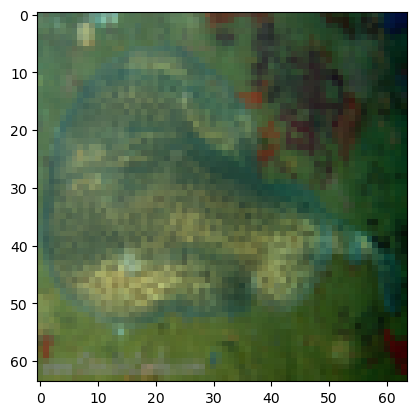

In [27]:
import numpy as np
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))
plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

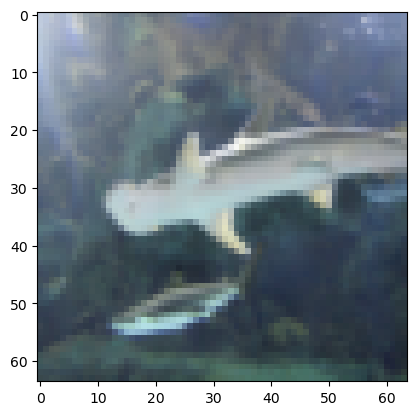

In [28]:
plt.imshow(np.transpose(img[1].numpy(), (1, 2, 0)))

In [29]:
from simple_vit import LafPatchExtractor

In [30]:
laf1=[[0.5,0,-0.5],[0,0.5,-0.5]]
laf2=[[0.5,0,-0.5],[0,0.5,0.5]]
laf3=[[0.5,0,0.5],[0,0.5,-0.5]]
laf4=[[0.5,0,0.5],[0,0.5,0.5]]

In [31]:
laf = torch.tensor([[laf1,laf2,laf3,laf4],[laf1,laf2,laf3,laf4]])

In [32]:
laf_to_patch = LafPatchExtractor(patch_size=64)

y = laf_to_patch(img, laf)

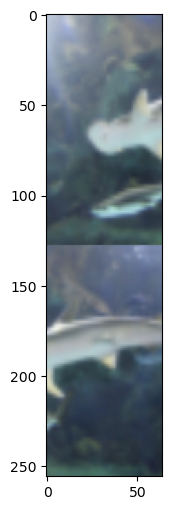

In [33]:
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(y[1].numpy(), (1, 2, 0)))

In [34]:
from simple_vit import LafPatchExtractor, SIFT_ViT, ViT, Ssd_ViT
from kornia.feature import harris_response

In [35]:
model = Ssd_ViT(detector=harris_response, image_size=IMAGE_SIZE, patch_size=PATCH_SIZE, num_classes=100, dim=512, depth=6, heads=8, mlp_dim=1024)

In [36]:
output = model(img)

In [37]:
shifts = model.detect_shifts(img)

In [38]:
shifts[0].shape

torch.Size([2, 16])

In [39]:
shifts

(tensor([[ 4, 15,  9, 12,  7,  0,  7, 12,  9,  9, 15,  9,  7,  1,  0,  9],
         [ 3, 13, 15,  1, 15,  7,  5, 13,  0,  5,  9,  1,  6,  4,  0, 15]]),
 tensor([[ 8,  9,  5,  4, 10,  9,  1,  3, 15,  0,  5,  9, 14,  3,  5,  5],
         [ 7,  8,  1,  8, 12, 12,  3,  4, 12, 10,  3,  2, 14, 10,  2, 13]]))

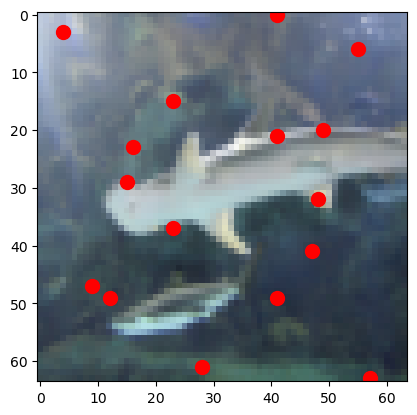

In [40]:
X=shifts[0][0]+model.lafs[:,0,2]
Y=shifts[0][1]+model.lafs[:,1,2]
plt.imshow(np.transpose(img[1].numpy(), (1, 2, 0)))
plt.scatter(X, Y, c='r', s=100)

In [41]:
patches = model.extract_patches(img, shifts)

In [42]:
patches.shape

torch.Size([2, 3, 256, 16])

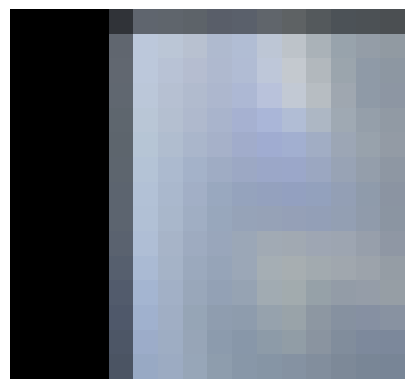

In [43]:
def show_image(tensor):
    if tensor.dim() == 4:
        tensor = tensor[0]
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor.clamp(0, 1)
    
    plt.imshow(tensor.numpy())
    plt.axis('off')
    plt.show()

show_image(patches[1,:, 0:15])

In [44]:
patches.shape

torch.Size([2, 3, 256, 16])

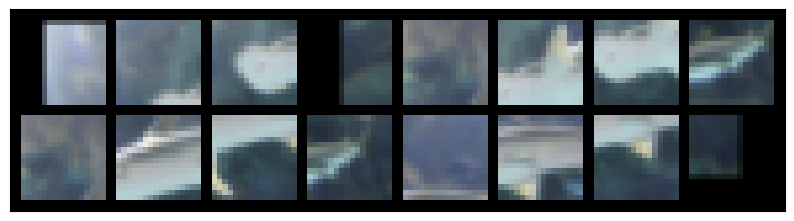

In [45]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
imgs = []
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for i in range(int(patches.shape[-2]/patches.shape[-1])):
    patch = patches[1,:, (i*16):(i*16+16),:]
    imgs.append(patch)

grid=make_grid(imgs)
show(grid)


In [46]:
imgs[0].shape

torch.Size([3, 16, 16])

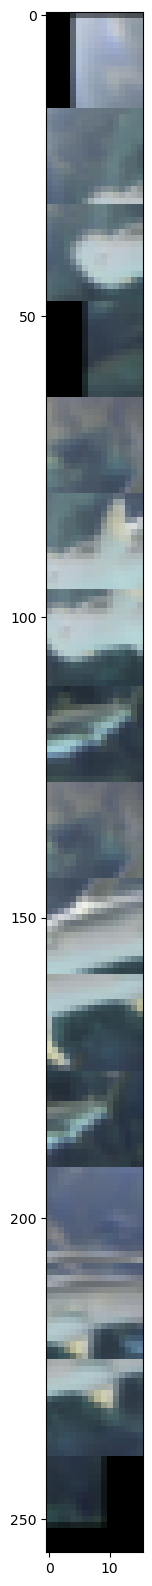

In [47]:
plt.figure(figsize=(8, 20))
plt.imshow(np.transpose(patches[1].numpy(), (1, 2, 0)))

In [48]:
model.lafs.shape

torch.Size([16, 2, 3])

In [49]:
model.lafs[:,0,2]

tensor([ 0.,  0.,  0.,  0., 16., 16., 16., 16., 32., 32., 32., 32., 48., 48.,
        48., 48.])

In [50]:
model.lafs[:,1,2]

tensor([ 0., 16., 32., 48.,  0., 16., 32., 48.,  0., 16., 32., 48.,  0., 16.,
        32., 48.])

In [54]:
img[0].flatten(-2,-1).shape

torch.Size([3, 4096])

In [60]:
sampled_indices = torch.multinomial(torch.tensor([[1,2,3],[8,10,9]], dtype=torch.float32), 2, replacement=False)

In [61]:
sampled_indices

tensor([[2, 1],
        [1, 2]])